# Projected-Gradient-Based Attack

* Load the learned relu/kwta/kaf-based models.
* Craft a PGD-attack for each of them and evaluate robustness based on the activation function used.
* Train every model against PGD and evaluate the resulting robustness.
* How does kwta and kaf activation functions affect the robustness of the network wrt traditional functions such as relu?

In [2]:
# Imports
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

## Load CIFAR10 and the Models

In [15]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [4]:
elu_cnn = tf.keras.models.load_model('../saved_models/elu_cnn')
kwta_cnn = tf.keras.models.load_model('../saved_models/kwta_cnn')
kaf_cnn = tf.keras.models.load_model('../saved_models/kaf_cnn')
elukaf_cnn = tf.keras.models.load_model('../saved_models/elukaf_cnn')

elu_cnn.summary()
kwta_cnn.summary()
kaf_cnn.summary()
elukaf_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)       

In [4]:
elu_cnn.evaluate(x_test, y_test, batch_size=32)
kwta_cnn.evaluate(x = x_test, y = y_test, batch_size=32)
kaf_cnn.evaluate(x_test, y_test, batch_size=32)
elukaf_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

313/313 [==============================] - 38s 121ms/step - loss: 7.6698 - accuracy: 0.8108


[7.669849395751953, 0.8108000159263611]

In [ ]:
## Part 3. Crafting a PGD Attack 

In [5]:
# We use the IBM Adversarial Robustness 360 Toolbox
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 486 kB 576 kB/s 
     |████████████████████████████████| 7.0 MB 4.1 MB/s 
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
     |████████████████████████████████| 298 kB 4.6 MB/s 


In [7]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks import ProjectedGradientDescent

# Wrap the model in a TensorFlowV2Classifier object
elu_cnn_art = TensorFlowV2Classifier(model=elu_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kwta_cnn_art = TensorFlowV2Classifier(model=kwta_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kaf_cnn_art = TensorFlowV2Classifier(model=kaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
elukaf_cnn_art = TensorFlowV2Classifier(model=elukaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [11]:
pgd_elu = ProjectedGradientDescent(classifier= elu_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_kwta = ProjectedGradientDescent(classifier= kwta_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_kaf = ProjectedGradientDescent(classifier= kaf_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_elukaf = ProjectedGradientDescent(classifier= elukaf_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)

In [24]:
# Take 100 random test samples
sample_ids = np.random.randint(10000, size=10)
x_test_sample = x_test[sample_ids, :, :, :]

time: 941 µs


In [13]:
# If loaded, every output of subsequent cell execution will include the time in min and sec it took to execute it.
!pip install ipython-autotime
%load_ext autotime

UsageError: Line magic function `%install_ext` not found.


In [25]:
# Generate pgd attacks for each classifier
#elu_x_adv_test = pgd_elu.generate(x_test_sample)
kwta_x_adv_test = pgd_kwta.generate(x_test_sample)
kaf_x_adv_test = pgd_kaf.generate(x_test_sample)
elukaf_x_adv_test = pgd_elukaf.generate(x_test_sample)
#np.save('adversarial_pgd_test_100', x_adv_test)

time: 26min 54s


In [26]:
np.save('kwta_pgd_test_10', kwta_x_adv_test)
np.save('kaf_pgd_test_10', kaf_x_adv_test)
np.save('elukaf_pgd_test_10', elukaf_x_adv_test)

time: 2.61 ms


In [42]:
# Retrieve the original images from the perturbed ones
# O(n)
def find_original_img(perturbed_img):
    
    min_diff = math.inf
    index = 0
    
    for i in range(0, x_test.shape[0]):
        diff = np.sum(abs(perturbed_img - x_test[i]))
        if diff < min_diff:
            min_diff = diff
            index = i
            
    return index

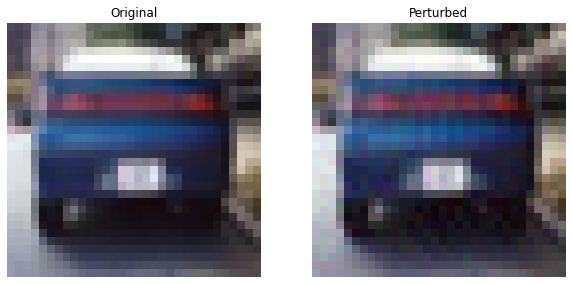

Real class: automobile
Predicted class: truck with 100.0 confidence


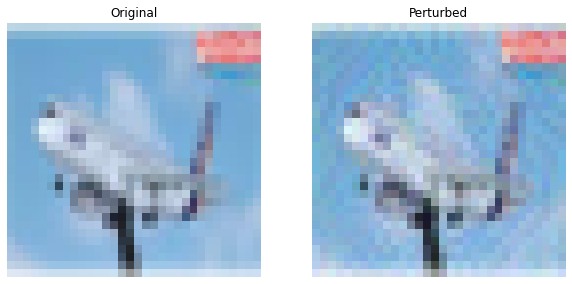

Real class: airplane
Predicted class: frog with 100.0 confidence


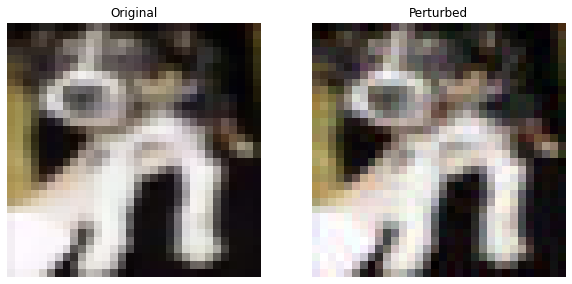

Real class: dog
Predicted class: deer with 100.0 confidence


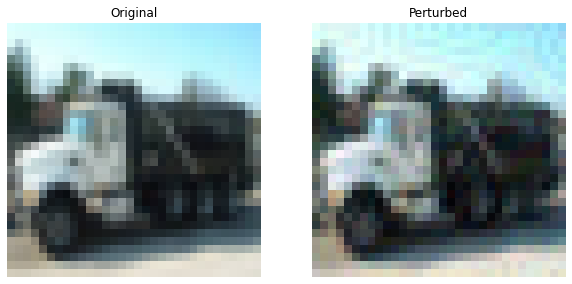

Real class: truck
Predicted class: automobile with 100.0 confidence


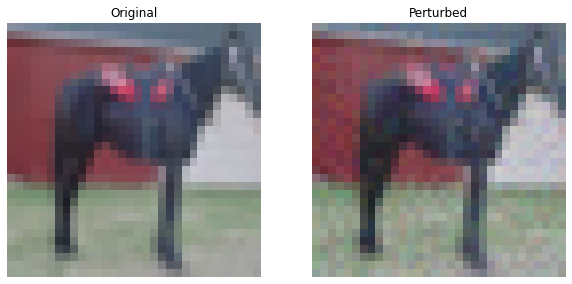

Real class: horse
Predicted class: deer with 100.0 confidence


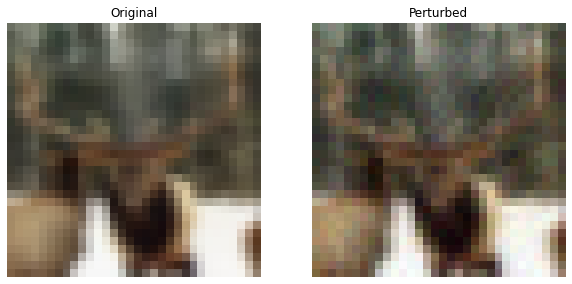

Real class: deer
Predicted class: deer with 100.0 confidence
WOOOOOOOOOW






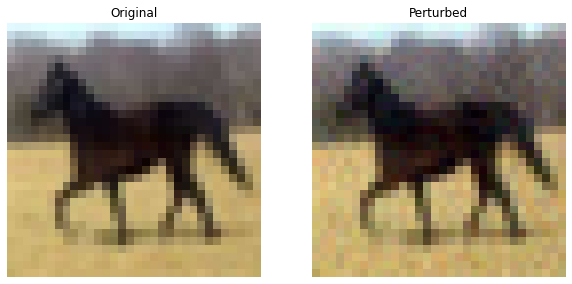

Real class: horse
Predicted class: deer with 100.0 confidence


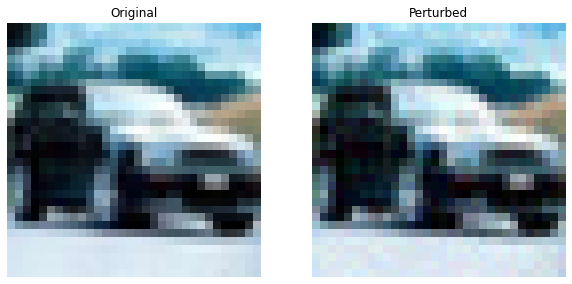

Real class: automobile
Predicted class: truck with 100.0 confidence


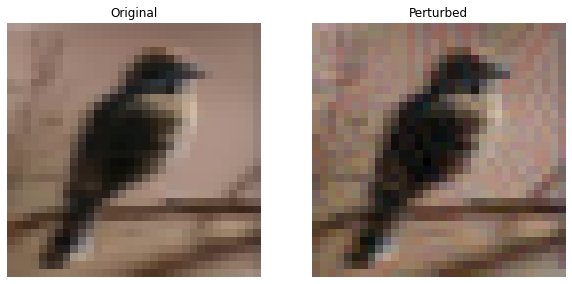

Real class: bird
Predicted class: cat with 100.0 confidence


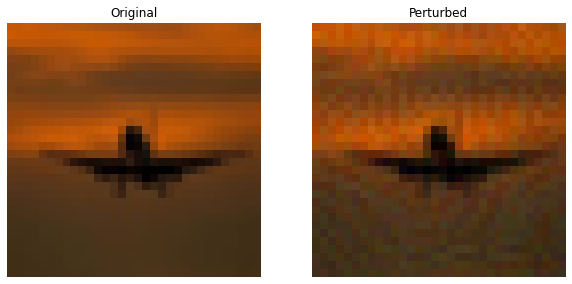

Real class: airplane
Predicted class: ship with 100.0 confidence


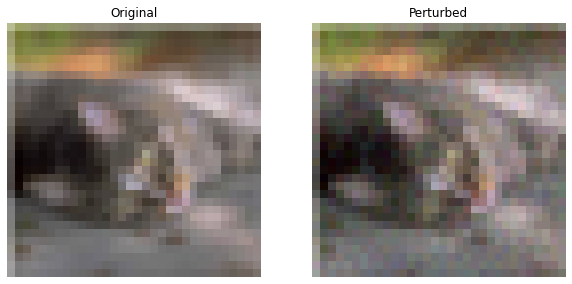

Real class: cat
Predicted class: frog with 100.0 confidence


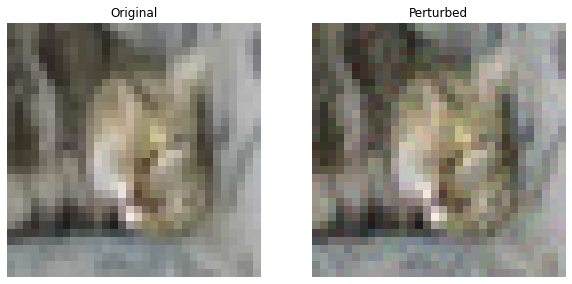

Real class: cat
Predicted class: frog with 100.0 confidence


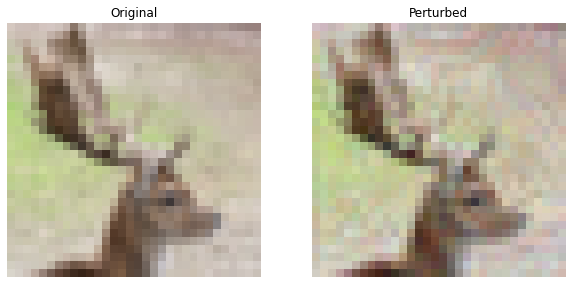

Real class: deer
Predicted class: cat with 100.0 confidence


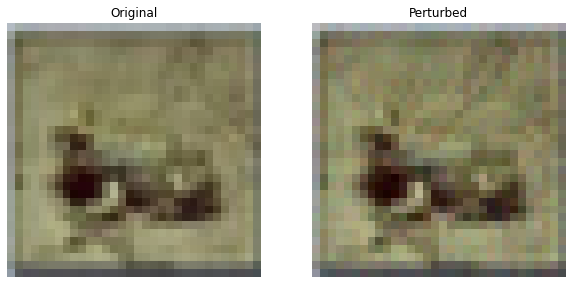

Real class: frog
Predicted class: deer with 100.0 confidence


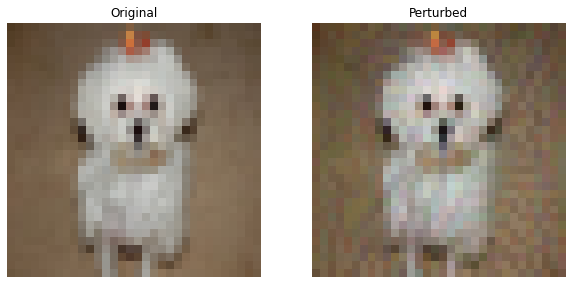

Real class: dog
Predicted class: bird with 100.0 confidence


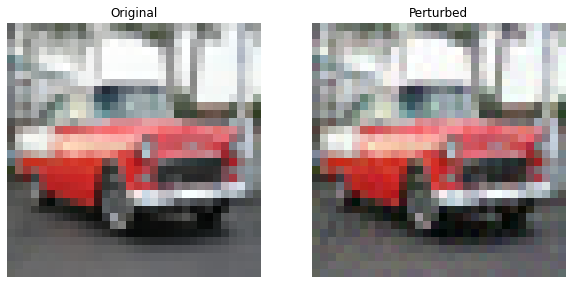

Real class: automobile
Predicted class: truck with 100.0 confidence


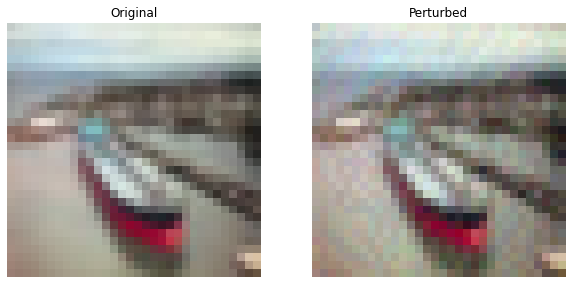

Real class: ship
Predicted class: frog with 100.0 confidence


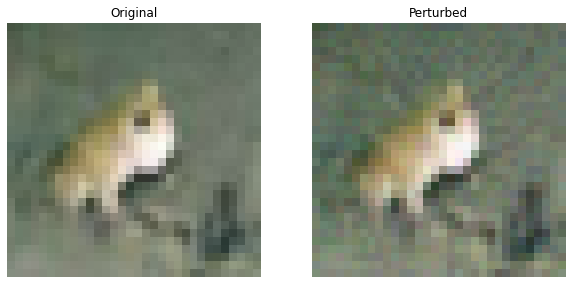

Real class: frog
Predicted class: deer with 100.0 confidence


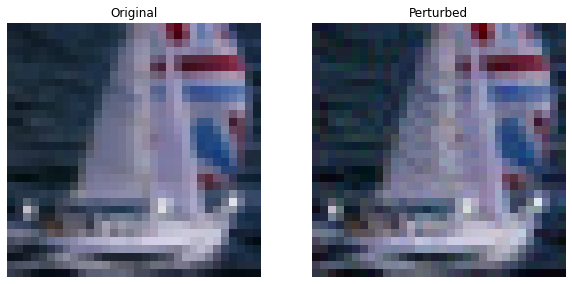

Real class: ship
Predicted class: cat with 100.0 confidence


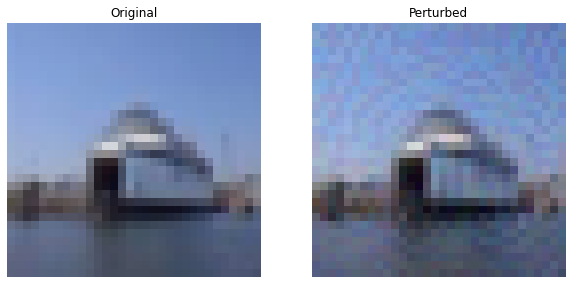

Real class: ship
Predicted class: truck with 100.0 confidence


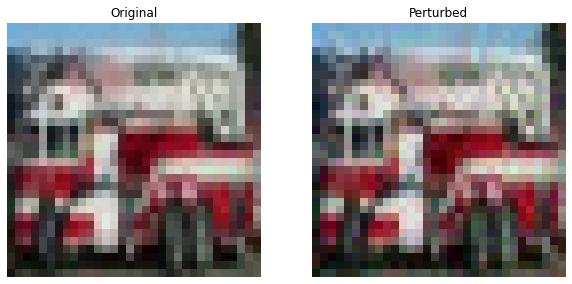

Real class: truck
Predicted class: deer with 100.0 confidence


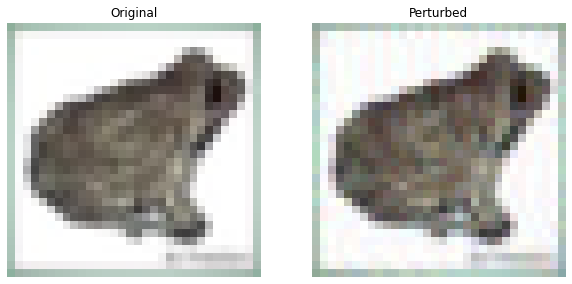

Real class: frog
Predicted class: cat with 100.0 confidence


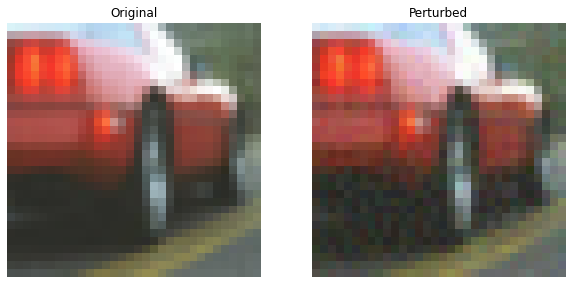

Real class: automobile
Predicted class: truck with 100.0 confidence


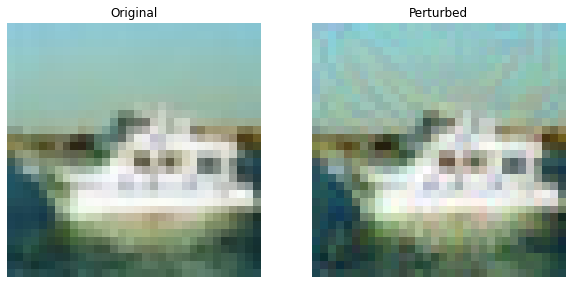

Real class: ship
Predicted class: airplane with 100.0 confidence


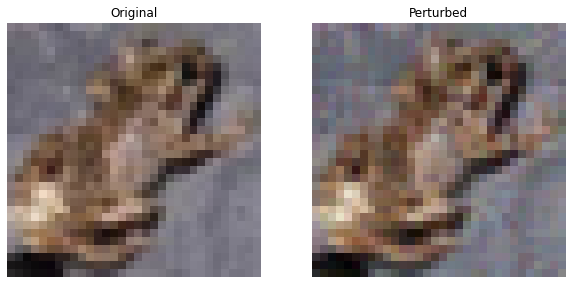

Real class: frog
Predicted class: dog with 99.0 confidence


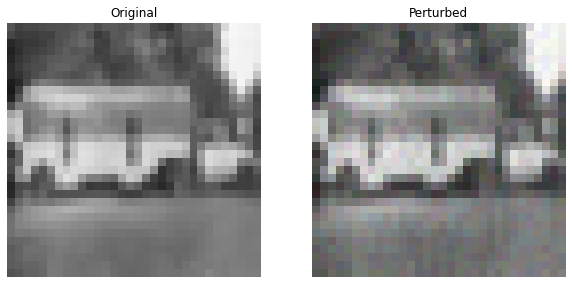

Real class: truck
Predicted class: ship with 100.0 confidence


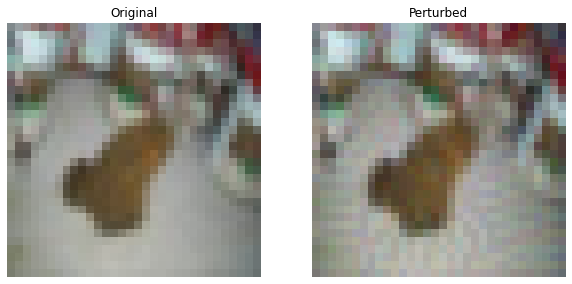

Real class: frog
Predicted class: horse with 99.0 confidence


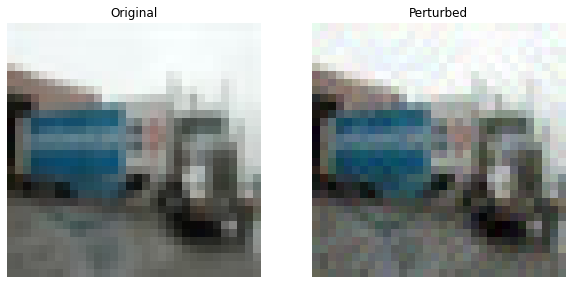

Real class: truck
Predicted class: frog with 100.0 confidence


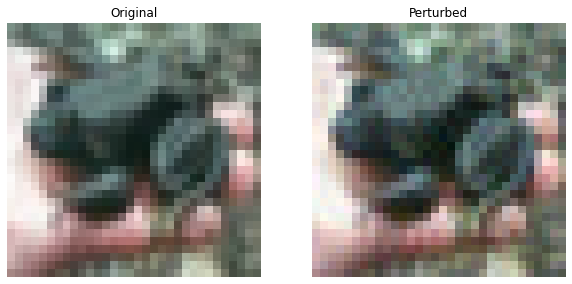

Real class: frog
Predicted class: bird with 100.0 confidence


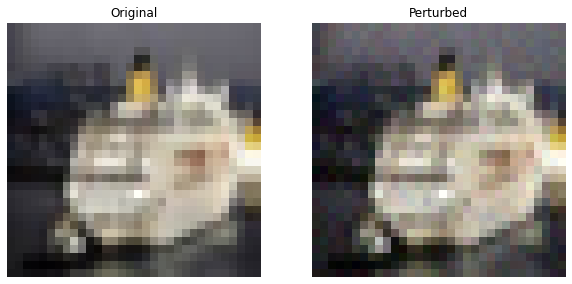

Real class: ship
Predicted class: frog with 100.0 confidence


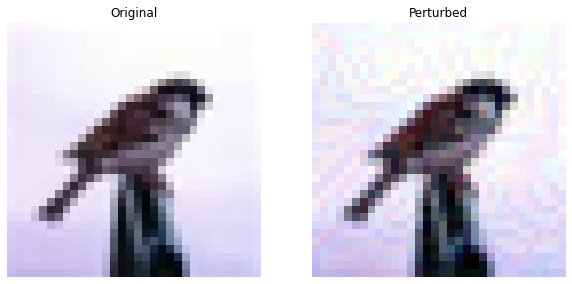

Real class: bird
Predicted class: airplane with 100.0 confidence


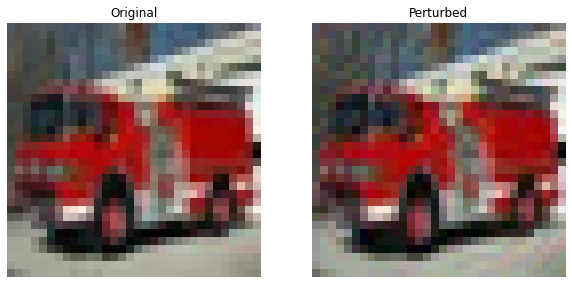

Real class: truck
Predicted class: automobile with 100.0 confidence


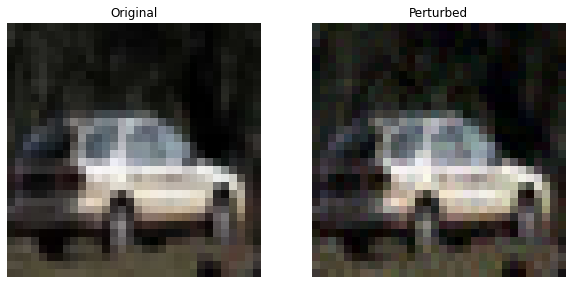

Real class: automobile
Predicted class: frog with 100.0 confidence


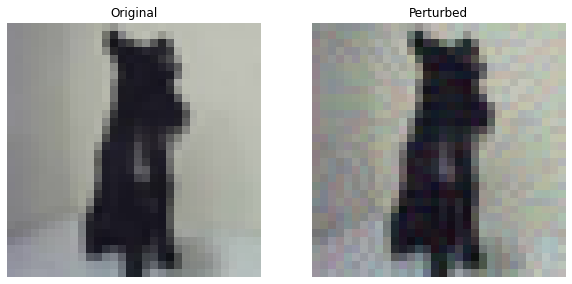

Real class: dog
Predicted class: deer with 100.0 confidence


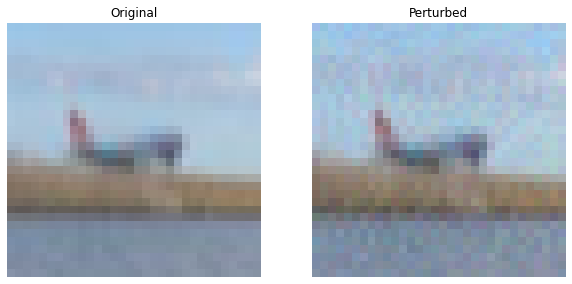

Real class: airplane
Predicted class: deer with 100.0 confidence


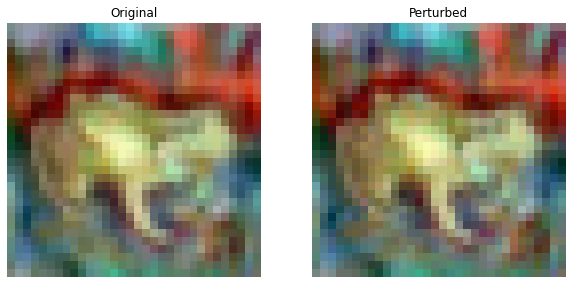

Real class: frog
Predicted class: cat with 76.0 confidence


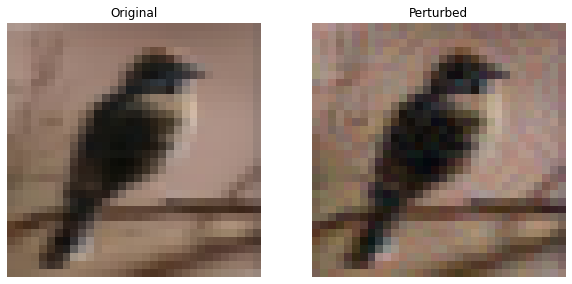

Real class: bird
Predicted class: dog with 100.0 confidence


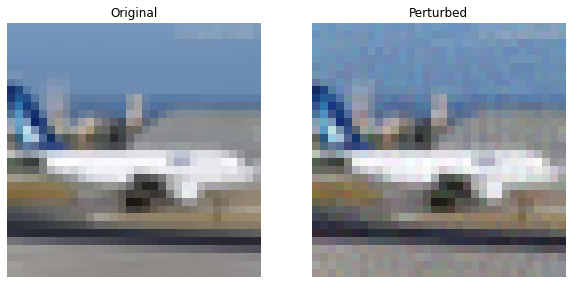

Real class: airplane
Predicted class: ship with 100.0 confidence


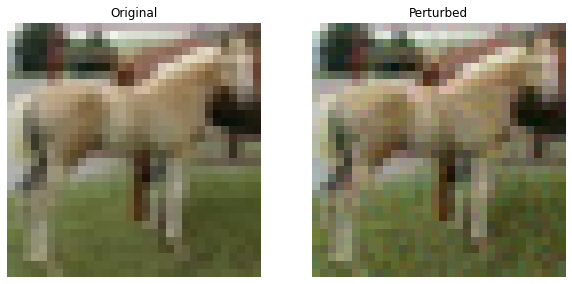

Real class: horse
Predicted class: deer with 100.0 confidence


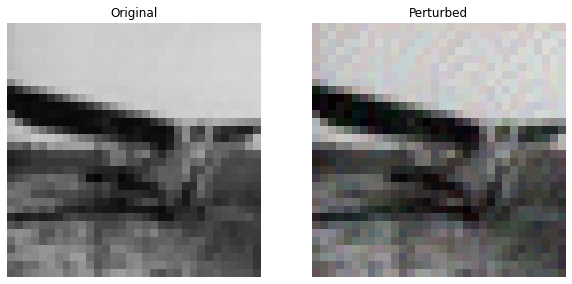

Real class: airplane
Predicted class: bird with 99.0 confidence


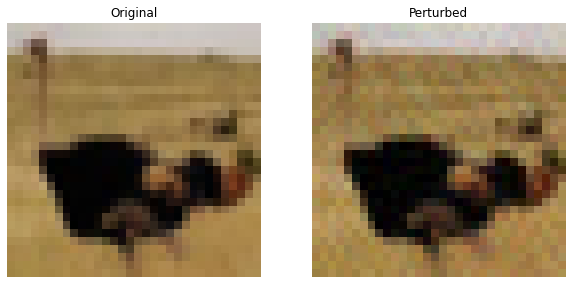

Real class: bird
Predicted class: frog with 100.0 confidence


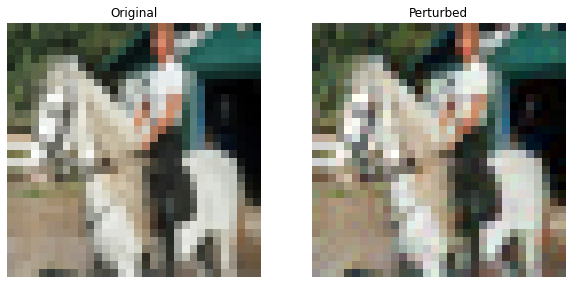

Real class: horse
Predicted class: dog with 100.0 confidence


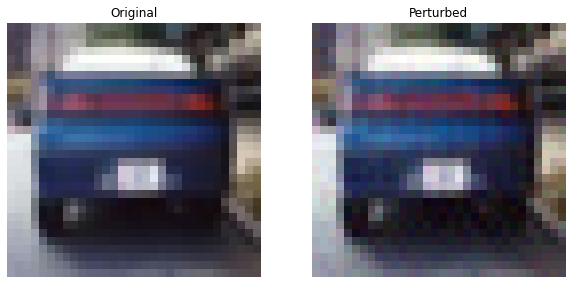

Real class: automobile
Predicted class: truck with 100.0 confidence


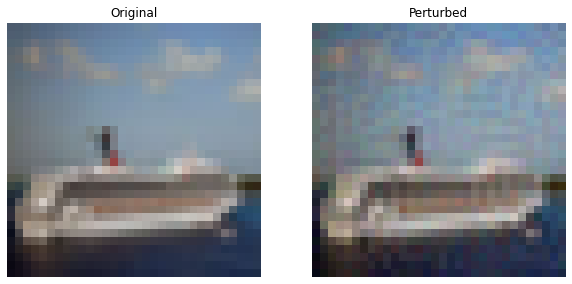

Real class: ship
Predicted class: truck with 100.0 confidence


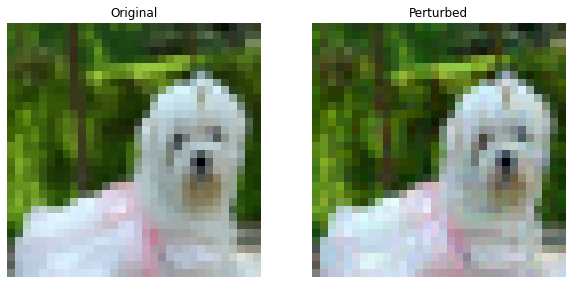

Real class: dog
Predicted class: horse with 100.0 confidence


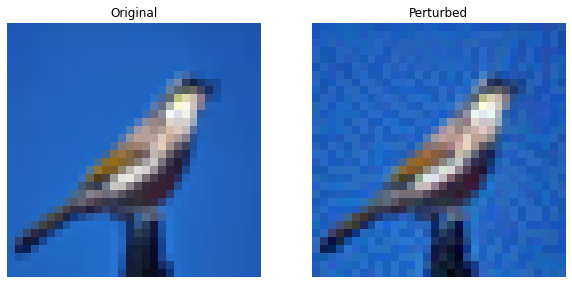

Real class: bird
Predicted class: airplane with 100.0 confidence


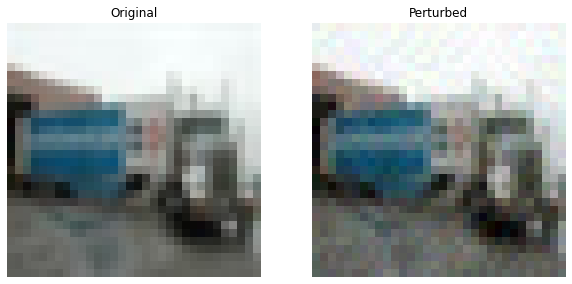

Real class: truck
Predicted class: frog with 100.0 confidence


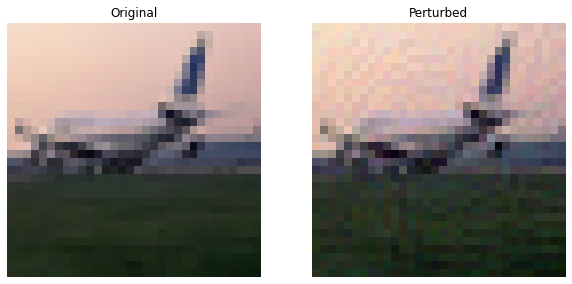

Real class: airplane
Predicted class: bird with 100.0 confidence


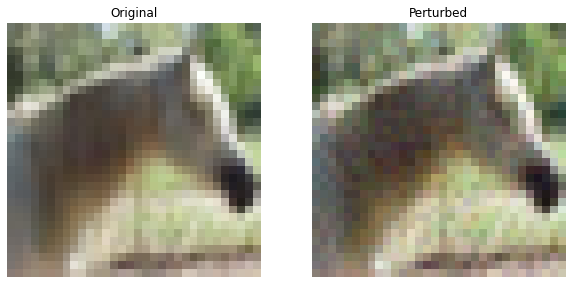

Real class: horse
Predicted class: frog with 100.0 confidence


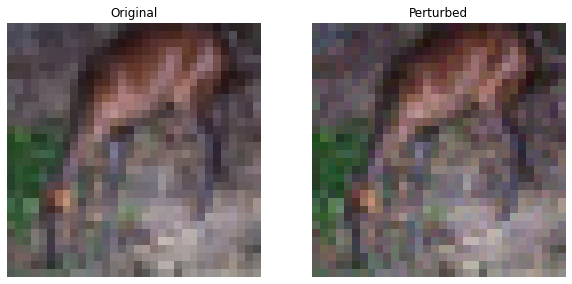

Real class: deer
Predicted class: frog with 100.0 confidence


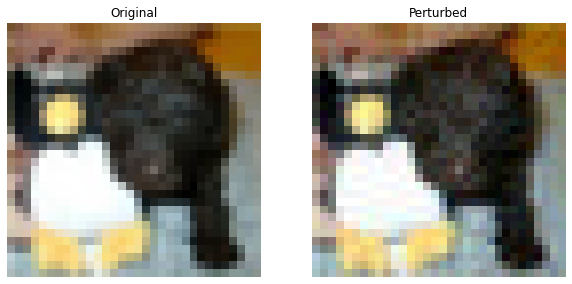

Real class: dog
Predicted class: cat with 100.0 confidence


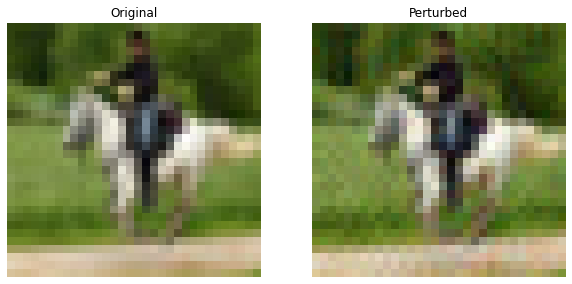

Real class: horse
Predicted class: dog with 100.0 confidence


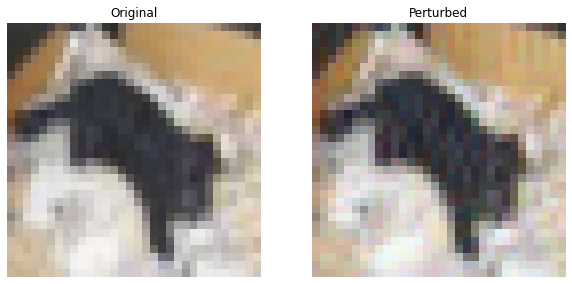

Real class: dog
Predicted class: dog with 100.0 confidence
WOOOOOOOOOW






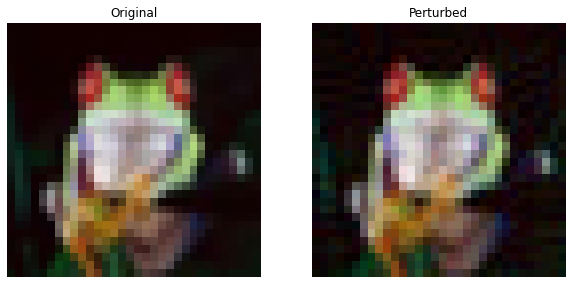

Real class: frog
Predicted class: dog with 100.0 confidence


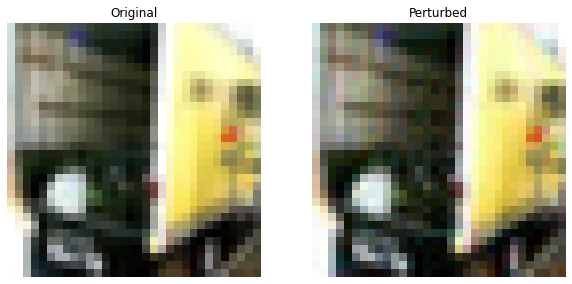

Real class: truck
Predicted class: cat with 100.0 confidence


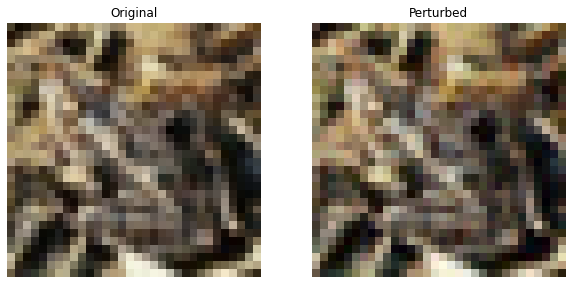

Real class: frog
Predicted class: cat with 100.0 confidence


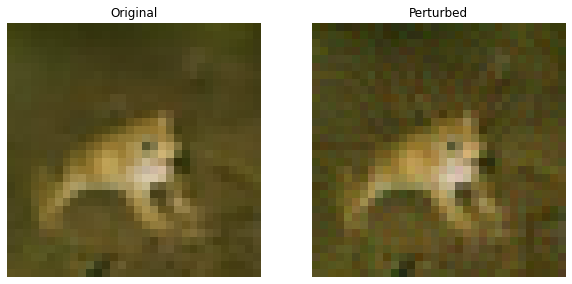

Real class: frog
Predicted class: deer with 100.0 confidence


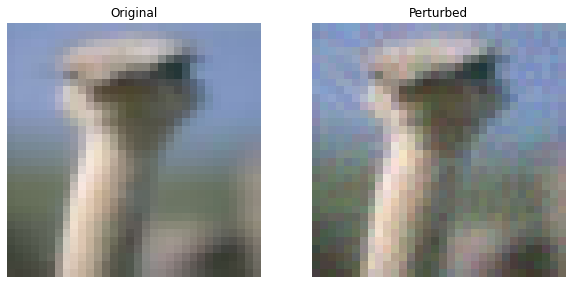

Real class: bird
Predicted class: deer with 100.0 confidence


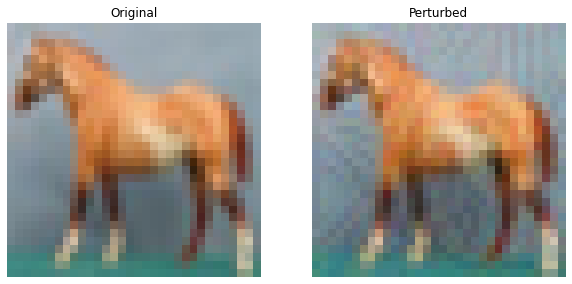

Real class: horse
Predicted class: dog with 100.0 confidence


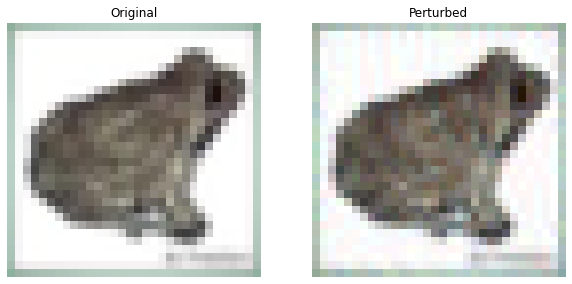

Real class: frog
Predicted class: cat with 100.0 confidence


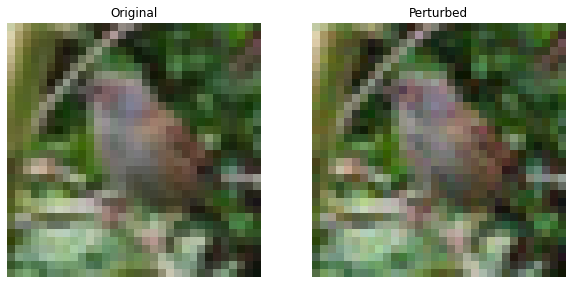

Real class: bird
Predicted class: frog with 100.0 confidence


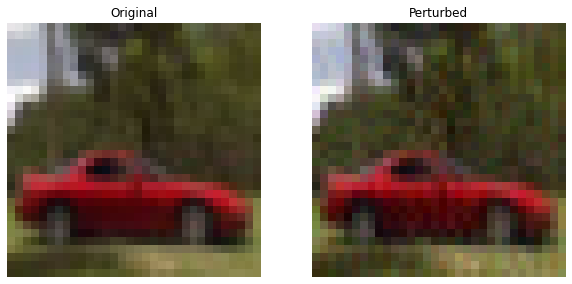

Real class: automobile
Predicted class: deer with 100.0 confidence


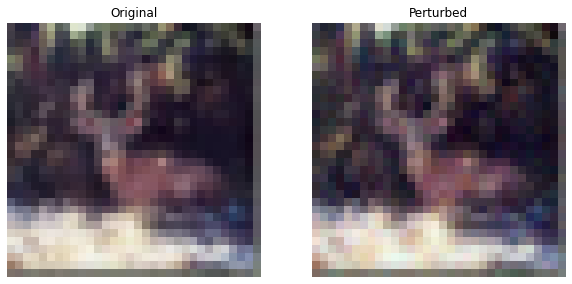

Real class: deer
Predicted class: dog with 99.0 confidence


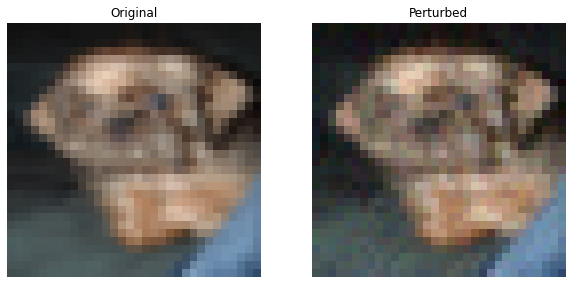

Real class: dog
Predicted class: frog with 100.0 confidence


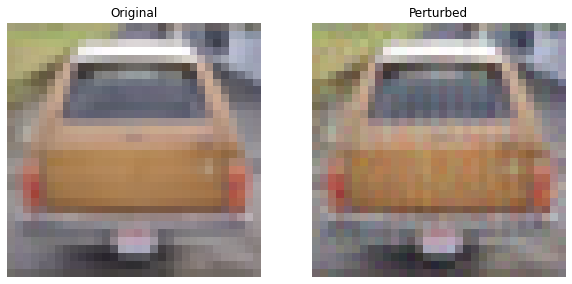

Real class: automobile
Predicted class: truck with 100.0 confidence


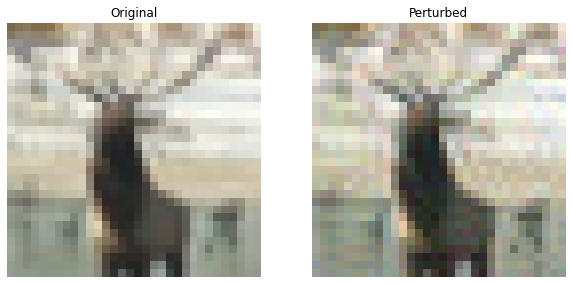

Real class: deer
Predicted class: bird with 100.0 confidence


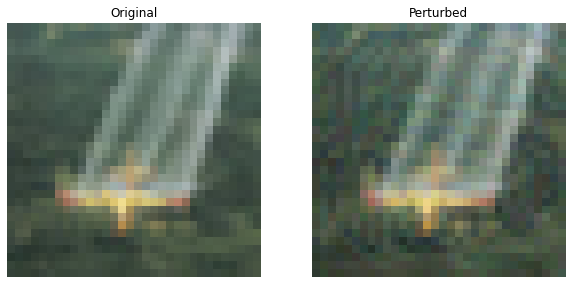

Real class: airplane
Predicted class: truck with 100.0 confidence


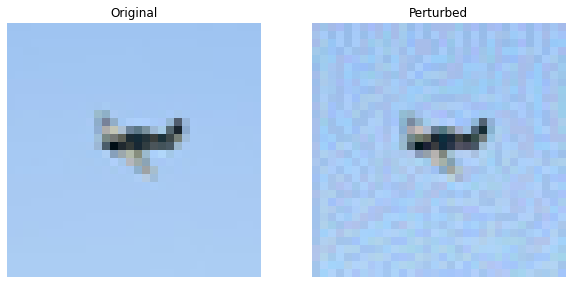

Real class: airplane
Predicted class: cat with 91.0 confidence


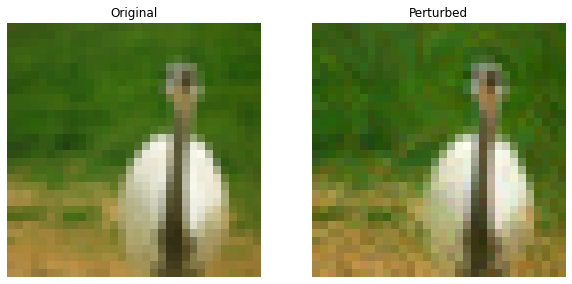

Real class: bird
Predicted class: bird with 100.0 confidence
WOOOOOOOOOW






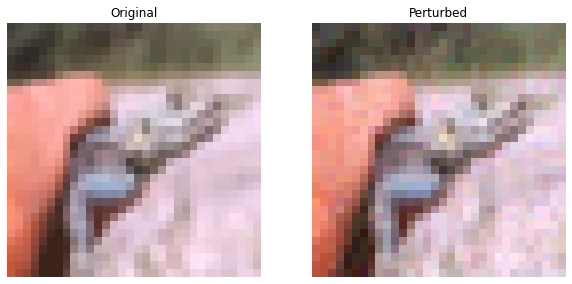

Real class: frog
Predicted class: deer with 100.0 confidence


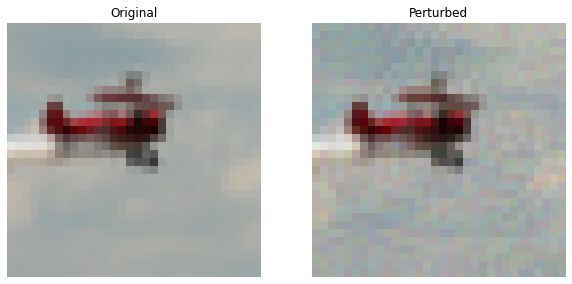

Real class: airplane
Predicted class: ship with 100.0 confidence


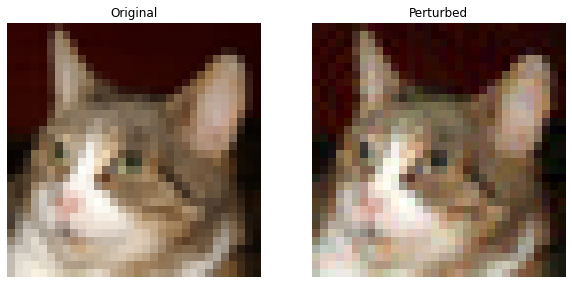

Real class: cat
Predicted class: dog with 100.0 confidence


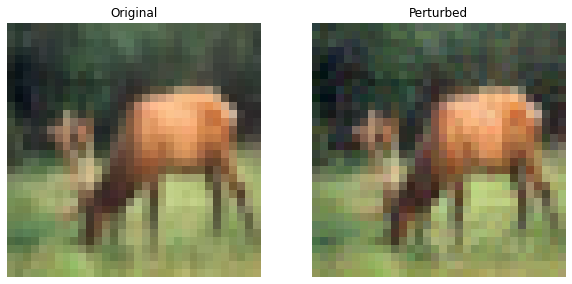

Real class: deer
Predicted class: horse with 100.0 confidence


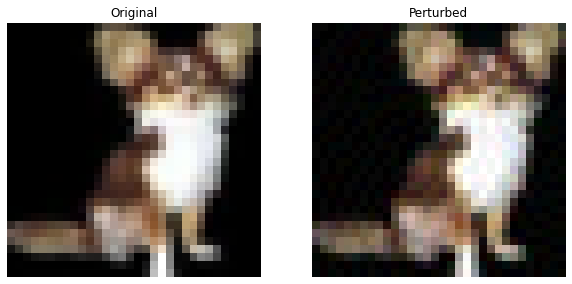

Real class: dog
Predicted class: frog with 100.0 confidence


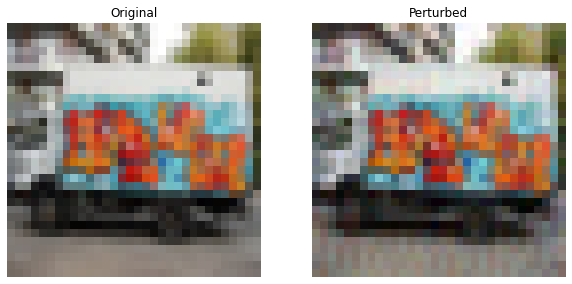

Real class: truck
Predicted class: ship with 100.0 confidence


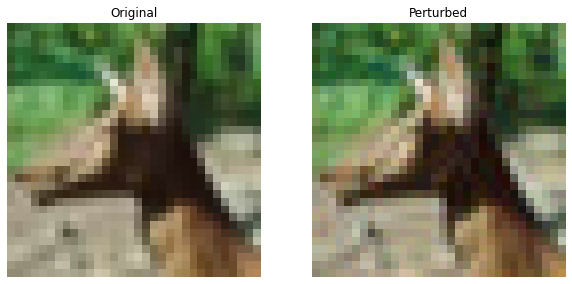

Real class: deer
Predicted class: horse with 100.0 confidence


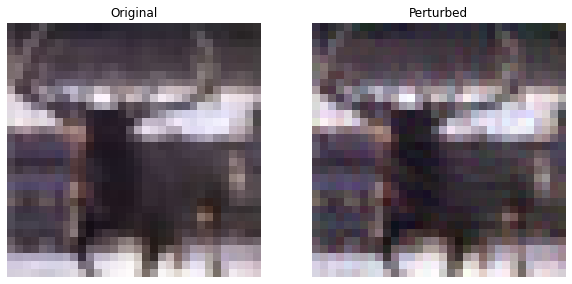

Real class: deer
Predicted class: ship with 100.0 confidence


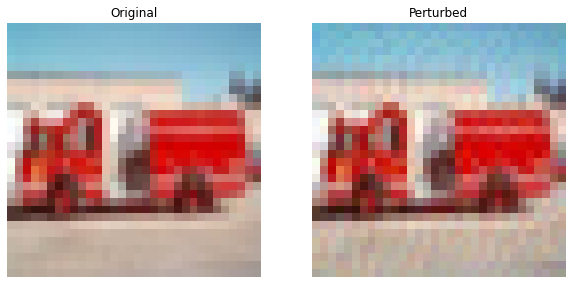

Real class: truck
Predicted class: ship with 100.0 confidence


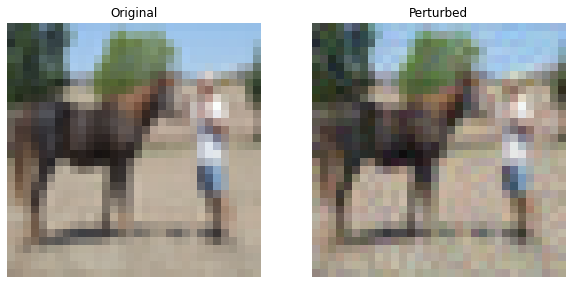

Real class: horse
Predicted class: deer with 100.0 confidence


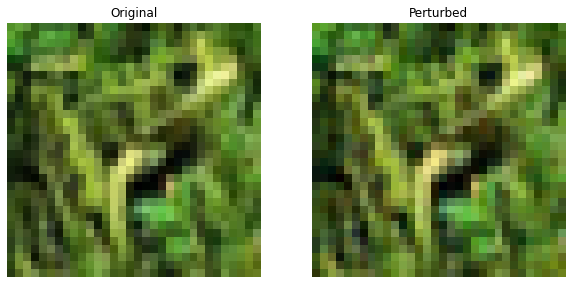

Real class: frog
Predicted class: deer with 100.0 confidence


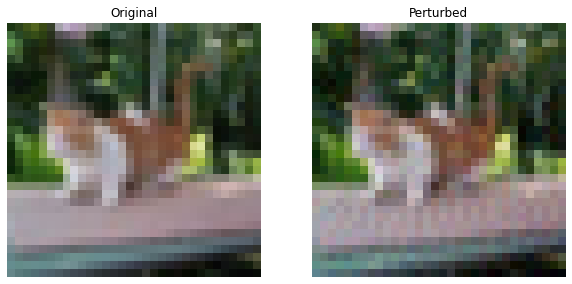

Real class: cat
Predicted class: deer with 100.0 confidence


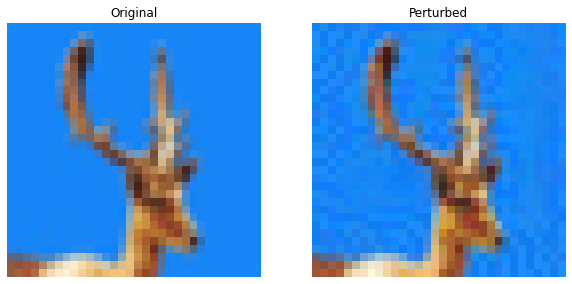

Real class: deer
Predicted class: bird with 100.0 confidence


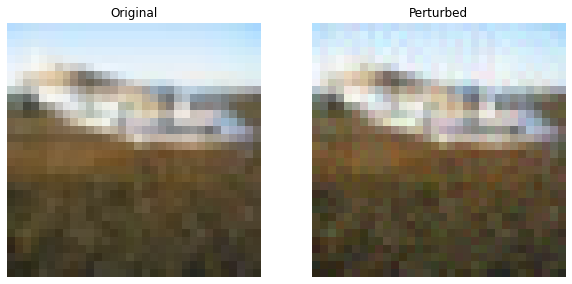

Real class: airplane
Predicted class: ship with 100.0 confidence


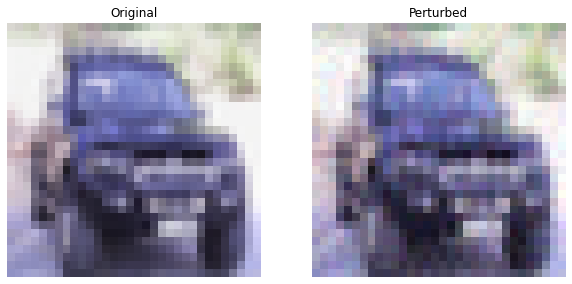

Real class: automobile
Predicted class: truck with 100.0 confidence


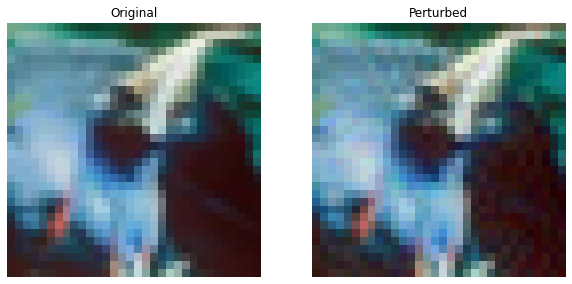

Real class: bird
Predicted class: deer with 100.0 confidence


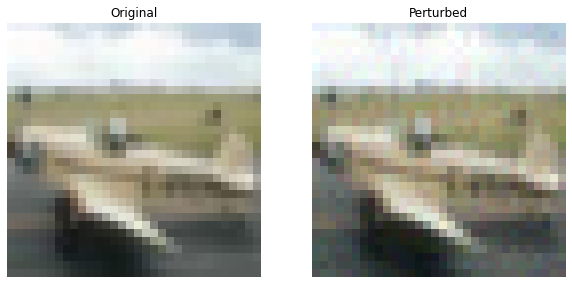

Real class: airplane
Predicted class: ship with 100.0 confidence


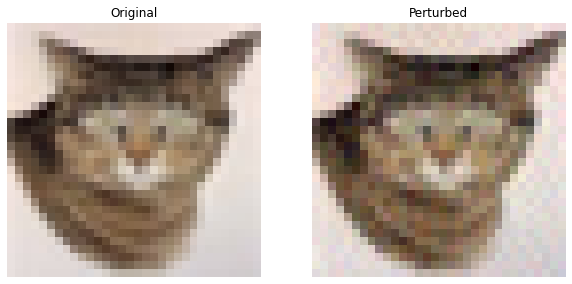

Real class: cat
Predicted class: frog with 100.0 confidence


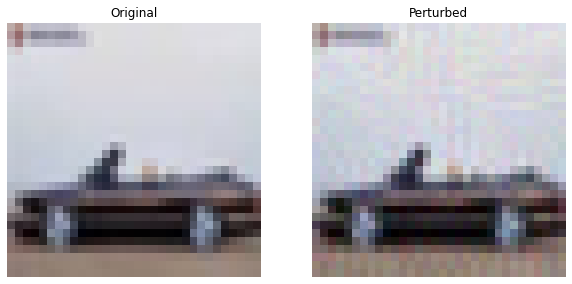

Real class: automobile
Predicted class: ship with 100.0 confidence


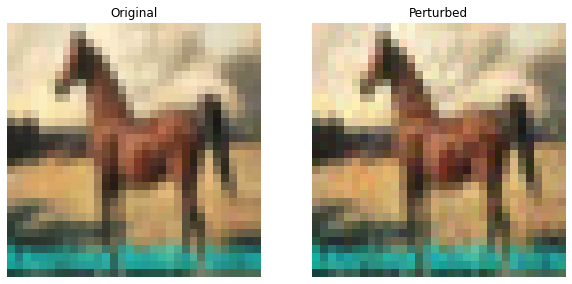

Real class: horse
Predicted class: deer with 100.0 confidence


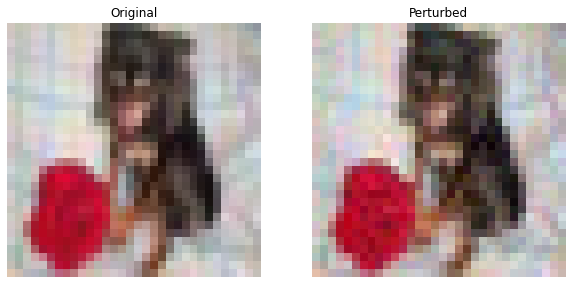

Real class: dog
Predicted class: cat with 100.0 confidence


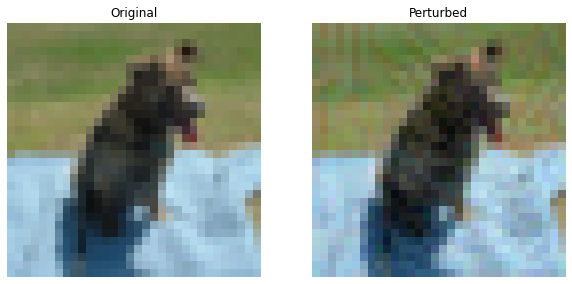

Real class: dog
Predicted class: cat with 100.0 confidence


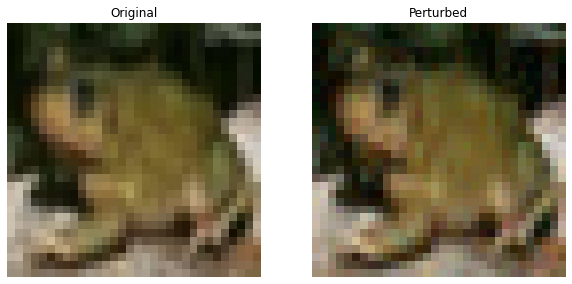

Real class: frog
Predicted class: dog with 100.0 confidence


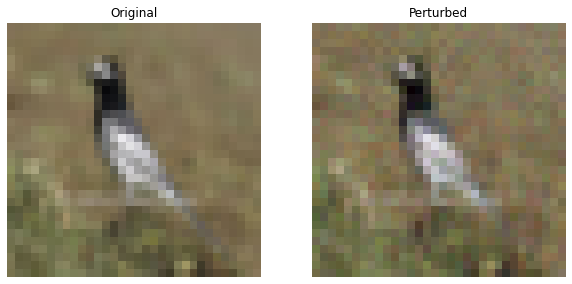

Real class: bird
Predicted class: deer with 100.0 confidence


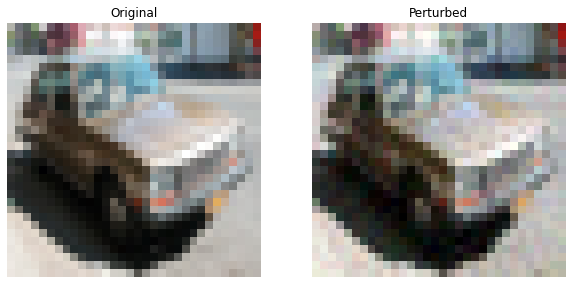

Real class: automobile
Predicted class: frog with 100.0 confidence


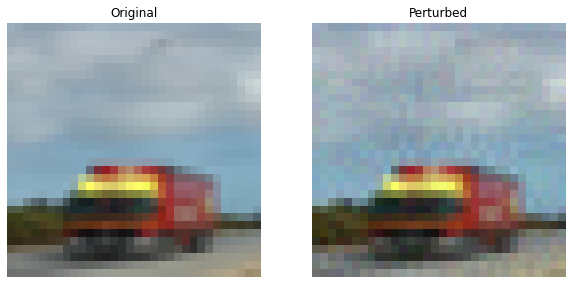

Real class: truck
Predicted class: ship with 100.0 confidence


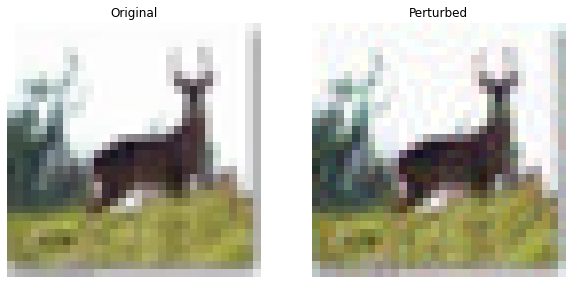

Real class: deer
Predicted class: frog with 100.0 confidence


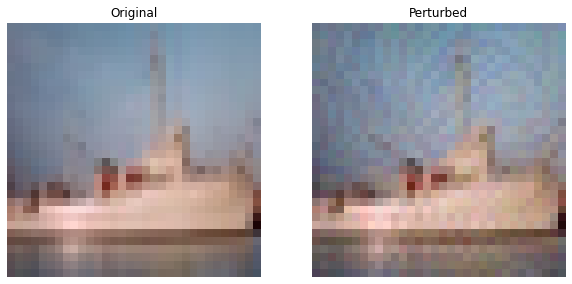

Real class: ship
Predicted class: bird with 100.0 confidence


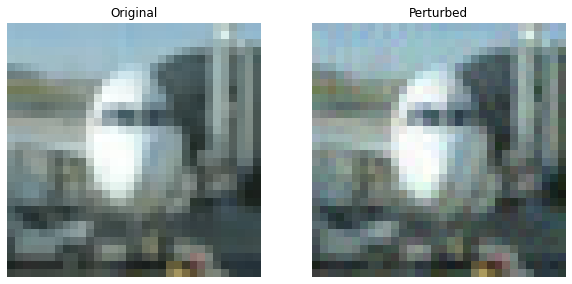

Real class: airplane
Predicted class: dog with 100.0 confidence


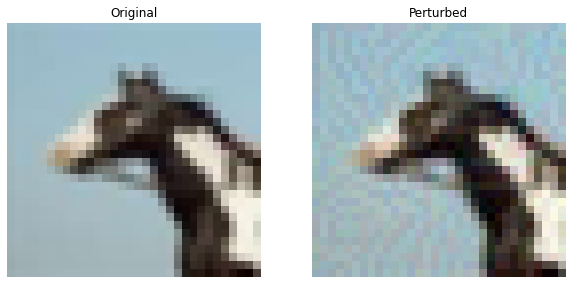

Real class: horse
Predicted class: bird with 100.0 confidence


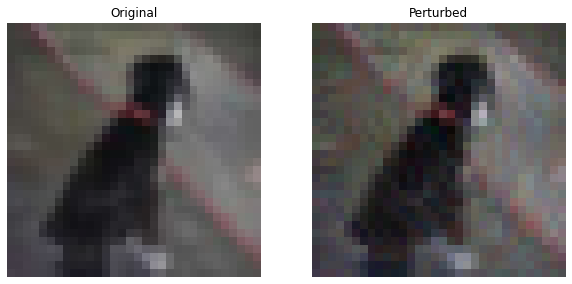

Real class: dog
Predicted class: dog with 100.0 confidence
WOOOOOOOOOW




Robustness 0.04


In [78]:
# Adversarial Prediction
from matplotlib import rcParams
rcParams['figure.figsize'] = 10 ,7 #Figure size

def plot_predict_attack_success(original_img, idx, perturbed_img, model):
    
    # Plot original next to perturbed one
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(original_img);
    ax[0].title.set_text('Original')
    ax[0].axis('off')
    ax[1].imshow(perturbed_img)
    ax[1].title.set_text('Perturbed')
    ax[1].axis('off')
    plt.show()
    plt.close()

    # Predict
    # Batch dimension needed for .predict
    perturbed_img = tf.expand_dims(perturbed_img, 0)

    original = classes[y_test[idx][0]]
    perturbed = classes[np.argmax(model.predict(perturbed_img))]

    print("Real class: {}".format(original))
    print("Predicted class: {} with {} confidence".format(perturbed , round(np.max(model.predict(perturbed_img)) * 100)) )

    if original != perturbed:
        return 0
    else:
        return 1 # Correct prediction even after pgd

nfool = 0
for perturbed_img in elu_pgd_attack_100:
    original_idx = find_original_img(perturbed_img)
    
    nfool += plot_predict_attack_success(x_test[original_idx], original_idx, perturbed_img, elu_cnn) 

print("Robustness {}".format(nfool/100))

In [65]:
classes[np.argmax(elu_cnn.predict(tf.expand_dims(x_test[260], 0)))]

'ship'

In [62]:
j

260

In [ ]:
# Our net is 90% certain of our image being a horse
classes= ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.imshow(x)
print(classes[np.argmax(reluCnn.predict(tf.expand_dims(x, 0)))])
print(reluCnn.predict(tf.expand_dims(x, 0)))

x_adv = pgd.generate(tf.expand_dims(x, 0))
plt.imshow(tf.squeeze(x_adv))

# Now its 99% sure it is a frog instead!

print(classes[np.argmax(reluCnn.predict(tf.expand_dims(tf.squeeze(x_adv), 0)))])
print(reluCnn.predict(tf.expand_dims(tf.squeeze(x_adv), 0)))

truck
[[2.7491248e-10 5.8994529e-09 1.0126156e-12 7.1903221e-12 2.1813637e-13
  1.8749566e-12 1.9218889e-12 1.7685761e-12 1.2318067e-09 1.0000000e+00]]
frog
[[3.8327137e-09 4.8840008e-09 2.1778924e-06 2.6310073e-07 3.7350421e-09
  4.0450656e-09 9.9999750e-01 1.4161208e-10 3.7393262e-09 3.3046614e-09]]
deer
[[4.6645260e-10 9.4811604e-13 2.4973057e-08 1.7611203e-08 1.0000000e+00
  2.8775446e-09 2.1572655e-10 5.0712978e-10 5.0684238e-11 3.8425974e-13]]
automobile
[[1.4815178e-09 9.9999964e-01 9.9620617e-11 5.8559607e-10 1.4618277e-12
  1.9168891e-10 2.2668574e-09 4.2324000e-12 4.3930224e-09 4.0779551e-07]]
deer
[[8.6853316e-09 1.2433215e-12 9.4684571e-09 5.9484337e-09 1.0000000e+00
  4.5635198e-09 1.4863379e-10 1.4960744e-09 7.5981346e-11 3.5462484e-11]]
deer
[[3.72148146e-10 3.45628826e-13 3.76784426e-09 2.52039301e-09
  1.00000000e+00 2.58390892e-10 5.79688381e-11 1.59342105e-11
  1.42174215e-11 4.41712856e-13]]
deer
[[5.9082975e-11 7.8230615e-14 1.5477423e-09 1.7198047e-09 1.0000000e+0

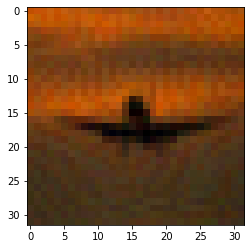

In [6]:
# Robustness Estimation
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

elu_pgd_attack_100 = np.load('elu_pgd_test_100.npy')

for x in elu_pgd_attack_100[:10]:
    
    plt.imshow(x)
    print(classes[np.argmax(elu_cnn.predict(tf.expand_dims(x, 0)))])
    print(elu_cnn.predict(tf.expand_dims(x, 0)))
    

In [34]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

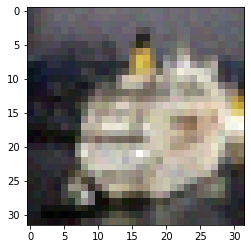

In [43]:
plt.imshow(elu_pgd_attack_100[29])

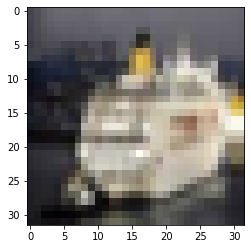

In [45]:
plt.imshow(x_test[j])

In [38]:
j

895